In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False  

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.inspection import permutation_importance

import shap

In [2]:
data = pd.read_csv(os.getcwd()+'\\data\\ABOX_raw_features_eb.csv')
print(data.shape)
data.head()

(1341, 73)


,material_id,pretty_formula,full_formula,unit_cell_formula,density,spacegroup.crystal_system,volume,band_gap,formation_energy_per_atom,e_above_hull,...,gamma,nA,nB,nX,rA,rB,rX,mu,t,tau
0,mp-10250,BaLiF3,Ba1Li1F3,"{'Ba': 1.0, 'Li': 1.0, 'F': 3.0}",5.020980,0,66.561793,6.5716,-3.767297,0.014824,...,90.000000,2.0,1.0,-1.0,1.61,0.76,1.33,0.571429,0.994686,3.394073
1,mp-1097061,CaTlF3,Ca1Tl1F3,"{'Ca': 1.0, 'Tl': 1.0, 'F': 3.0}",5.456459,2,91.740879,4.8393,-3.321972,0.018100,...,89.962853,1.0,2.0,-1.0,1.70,1.00,1.33,0.751880,0.919542,3.533750
2,mp-998150,CaTlF3,Ca1Tl1F3,"{'Ca': 1.0, 'Tl': 1.0, 'F': 3.0}",5.446106,3,91.915271,4.8398,-3.321913,0.018159,...,90.090621,1.0,2.0,-1.0,1.70,1.00,1.33,0.751880,0.919542,3.533750
3,mp-12262,CsBeF3,Cs4Be4F12,"{'Cs': 4.0, 'Be': 4.0, 'F': 12.0}",3.397007,3,388.933579,6.6615,-3.425382,0.000000,...,90.000000,1.0,2.0,-1.0,1.88,0.45,1.33,0.338346,1.275176,4.877529
4,mp-1017555,CsBeF3,Cs1Be1F3,"{'Cs': 1.0, 'Be': 1.0, 'F': 3.0}",5.026564,0,65.711400,5.3850,-2.762829,0.662552,...,90.000000,1.0,2.0,-1.0,1.88,0.45,1.33,0.338346,1.275176,4.877529


In [3]:
num = data.isnull().sum()
miss = data.isnull() 
print(data.isnull().sum().sum()) 
print(data[data.isnull().any(axis=1)].shape)

0
(0, 73)


In [4]:
colNameDict = {'formation_energy_per_atom':'Ef',
               'e_above_hull':'Ehull', 
               'spacegroup.crystal_system':'cry_sys'}
data.rename(columns=colNameDict, inplace=True)

In [5]:
data.columns

Index(['material_id', 'pretty_formula', 'full_formula', 'unit_cell_formula',
       'density', 'cry_sys', 'volume', 'band_gap', 'Ef', 'Ehull', 'z_A', 'z_B',
       'z_X', 'row_A', 'row_B', 'row_X', 'grp_A', 'grp_B', 'grp_X',
       'atom_mass_A', 'atom_mass_B', 'atom_mass_X', 'mol_vol_A', 'mol_vol_B',
       'mol_vol_X', 'ion_rad_A', 'ion_rad_B', 'ion_rad_X', 'cov_rad_A',
       'cov_rad_B', 'cov_rad_X', 'vdw_rad_A', 'vdw_rad_B', 'vdw_rad_X', 'x_A',
       'x_B', 'x_X', 'ea_A', 'ea_B', 'ea_X', 'k_A', 'k_B', 'k_X', 'val_A',
       'val_B', 'val_X', 'bp_A', 'bp_B', 'bp_X', 'mp_A', 'mp_B', 'mp_X',
       'heat_fus_A', 'heat_fus_B', 'heat_fus_X', 'ie_A', 'ie_B', 'ie_X', 'a',
       'b', 'c', 'alpha', 'beta', 'gamma', 'nA', 'nB', 'nX', 'rA', 'rB', 'rX',
       'mu', 't', 'tau'],
      dtype='object')

In [6]:
data_1 = data.drop(['material_id', 'pretty_formula', 'full_formula',
                    'unit_cell_formula'], axis=1)

In [7]:
print(data_1.shape)
data_1.columns

(1341, 69)


Index(['density', 'cry_sys', 'volume', 'band_gap', 'Ef', 'Ehull', 'z_A', 'z_B',
       'z_X', 'row_A', 'row_B', 'row_X', 'grp_A', 'grp_B', 'grp_X',
       'atom_mass_A', 'atom_mass_B', 'atom_mass_X', 'mol_vol_A', 'mol_vol_B',
       'mol_vol_X', 'ion_rad_A', 'ion_rad_B', 'ion_rad_X', 'cov_rad_A',
       'cov_rad_B', 'cov_rad_X', 'vdw_rad_A', 'vdw_rad_B', 'vdw_rad_X', 'x_A',
       'x_B', 'x_X', 'ea_A', 'ea_B', 'ea_X', 'k_A', 'k_B', 'k_X', 'val_A',
       'val_B', 'val_X', 'bp_A', 'bp_B', 'bp_X', 'mp_A', 'mp_B', 'mp_X',
       'heat_fus_A', 'heat_fus_B', 'heat_fus_X', 'ie_A', 'ie_B', 'ie_X', 'a',
       'b', 'c', 'alpha', 'beta', 'gamma', 'nA', 'nB', 'nX', 'rA', 'rB', 'rX',
       'mu', 't', 'tau'],
      dtype='object')

### band gap prediction with Ef & Ehull
1.default parameters

In [8]:
X = data_1.drop(['band_gap'], axis=1)
print(type(X), X.shape)

y = data_1[['band_gap']].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3
)
print("training set：",len(X_train)," test set：",  len(X_test))

<class 'pandas.core.frame.DataFrame'> (1341, 68)
training set： 1072  test set： 269


In [9]:
tuned_params_gbr = {
    "random_state": [3]
}

In [10]:
params = {}
for k,v in tuned_params_gbr.items():
    params[k] = v[0]
gbr = ensemble.GradientBoostingRegressor(**params)

In [11]:
model = gbr.fit(X_train, y_train)

In [12]:
GBR_test_pred = gbr.predict(X_test)
r2 = r2_score(y_test, GBR_test_pred)
RMSE = mean_squared_error(y_test, GBR_test_pred)**0.5
MAE = mean_absolute_error(y_test, GBR_test_pred)
    
print('r^2:', r2, '\nRMSE:', RMSE, '\nMAE:', MAE)

r^2: 0.7928232458306479 
RMSE: 0.6879321323193336 
MAE: 0.5190405866792026


In [13]:
from sklearn.model_selection import cross_val_score

In [14]:
scores = cross_val_score(gbr, X_train, y_train, cv=5)

In [15]:
print(scores)
print(scores.mean())

[0.71895288 0.67586369 0.71656928 0.72556792 0.80106283]
0.727603319765066


2.optimized parameters

In [16]:
tuned_params_gbr = {'random_state': [3],
                     'n_estimators': [1400],
                     'learning_rate': [0.06999999999999999],
                     'max_depth': [5],
                     'min_samples_split': [3],
                     'min_samples_leaf': [1],
                     'max_features': [8]}
tuned_params_gbr

{'random_state': [3],
 'n_estimators': [1400],
 'learning_rate': [0.06999999999999999],
 'max_depth': [5],
 'min_samples_split': [3],
 'min_samples_leaf': [1],
 'max_features': [8]}

In [17]:
params = {}
for k,v in tuned_params_gbr.items():
    params[k] = v[0]
gbr = ensemble.GradientBoostingRegressor(**params)

In [18]:
model = gbr.fit(X_train, y_train)

In [19]:
GBR_test_pred = gbr.predict(X_test)
r2 = r2_score(y_test, GBR_test_pred)
RMSE = mean_squared_error(y_test, GBR_test_pred)**0.5
MAE = mean_absolute_error(y_test, GBR_test_pred)

least_feature_list = ["first"] 
r2_list = [r2]          
RMSE_list = [RMSE]
MAE_list = [MAE]
    
print('r^2:', r2, '\nRMSE:', RMSE, '\nMAE:', MAE)

r^2: 0.8702851948456258 
RMSE: 0.5443395082867823 
MAE: 0.3861708873453046


In [20]:
df_result = pd.DataFrame({"test":y_test,
                          "pred":GBR_test_pred})
df_result.to_csv(os.getcwd()+"\\result\\data\\bandgap_optimized.csv", index=False)

In [21]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(gbr, X_train, y_train, cv=5)

In [22]:
print(scores)
print(scores.mean())

[0.78499741 0.73761726 0.77513805 0.79773951 0.88465004]
0.7960284528765534


#### shap_based feature importance

In [23]:
delete_features = ['grp_X', 'bp_X', 'mp_B', 'ea_X', 'row_X', 'c', 'nB', 'cov_rad_A', 
                   'val_X', 'heat_fus_X', 'tau', 'nA', 'x_A', 'rX', 'beta', 
                   'heat_fus_A', 'ion_rad_A', 'vdw_rad_A', 'k_B', 'atom_mass_X', 
                   'val_B', 'ion_rad_B', 'heat_fus_B', 'volume', 'ie_A', 'row_A', 
                   'ea_B', 'cry_sys', 'ea_A', 'gamma', 'z_X', 'row_B', 'z_A', 'mp_X', 
                   'k_X', 'a', 'nX', 'mol_vol_X', 'ion_rad_X', 'cov_rad_X', 'alpha', 'rB', 
                   'cov_rad_B', 'vdw_rad_B', 'ie_B', 'z_B', 'val_A', 'rA', 'vdw_rad_X', 'bp_A', 'x_X']

In [24]:
new_X = X.drop(delete_features, axis=1)

In [25]:
data_cor = np.corrcoef(new_X,rowvar=0)
data_cor = pd.DataFrame(data=data_cor,columns=new_X.columns,index=new_X.columns) 

In [26]:
data_cor

,density,Ef,Ehull,grp_A,grp_B,atom_mass_A,atom_mass_B,mol_vol_A,mol_vol_B,x_B,k_A,bp_B,mp_A,ie_X,b,mu,t
density,1.000000,-0.240864,-0.022271,0.536650,0.041053,0.624537,0.465640,-0.276046,0.054208,-0.173170,-0.346624,0.171625,0.511033,-0.085635,-0.243842,0.254597,-0.227075
Ef,-0.240864,1.000000,0.001746,0.058698,0.340068,-0.045778,0.121016,0.091619,0.197126,0.564507,0.259257,-0.348238,-0.210671,-0.384982,0.291841,-0.288265,0.142721
Ehull,-0.022271,0.001746,1.000000,0.026815,-0.025442,-0.126913,-0.085032,-0.157805,-0.115480,-0.015528,0.029197,0.057138,0.091423,0.145377,-0.153645,-0.022644,-0.104844
grp_A,0.536650,0.058698,0.026815,1.000000,0.230274,0.510707,-0.005968,-0.479382,-0.017722,0.113580,-0.031921,-0.057070,0.374657,-0.162546,-0.055089,-0.153995,-0.157300
grp_B,0.041053,0.340068,-0.025442,0.230274,1.000000,0.037759,0.144213,-0.164942,0.291533,0.665023,0.159278,-0.479018,0.083782,-0.173601,0.120610,-0.282484,0.208917
atom_mass_A,0.624537,-0.045778,-0.126913,0.510707,0.037759,1.000000,0.029153,0.114032,0.010564,-0.060343,-0.474401,0.027887,0.279805,-0.283309,-0.051004,0.016287,0.115994
atom_mass_B,0.465640,0.121016,-0.085032,-0.005968,0.144213,0.029153,1.000000,0.043237,0.527686,-0.085479,-0.068332,-0.034905,0.076228,-0.087037,0.053610,0.554601,-0.308674
mol_vol_A,-0.276046,0.091619,-0.157805,-0.479382,-0.164942,0.114032,0.043237,1.000000,0.197562,-0.090708,-0.165247,-0.065318,-0.546489,-0.073102,0.076672,0.166727,0.383250
mol_vol_B,0.054208,0.197126,-0.115480,-0.017722,0.291533,0.010564,0.527686,0.197562,1.000000,-0.000740,0.083470,-0.519330,-0.118364,-0.246854,0.129689,0.341847,-0.106191
x_B,-0.173170,0.564507,-0.015528,0.113580,0.665023,-0.060343,-0.085479,-0.090708,-0.000740,1.000000,0.248147,-0.361281,-0.064299,-0.069549,0.065353,-0.526527,0.485356


In [27]:
def plot_corrcoef_heatmap(feature, fig_size):

    data_cor = np.corrcoef(feature,rowvar=0)
    data_cor = pd.DataFrame(data=data_cor,columns=feature.columns,index=feature.columns)
    
    plt.figure(figsize=fig_size)
    ax = sns.heatmap(data_cor,square=True,annot=True,fmt = ".3f",
                     linewidths=.5,cmap="YlGnBu",
                     cbar_kws={"fraction":0.046, "pad":0.03})

    plt.show()
    
    return data_cor

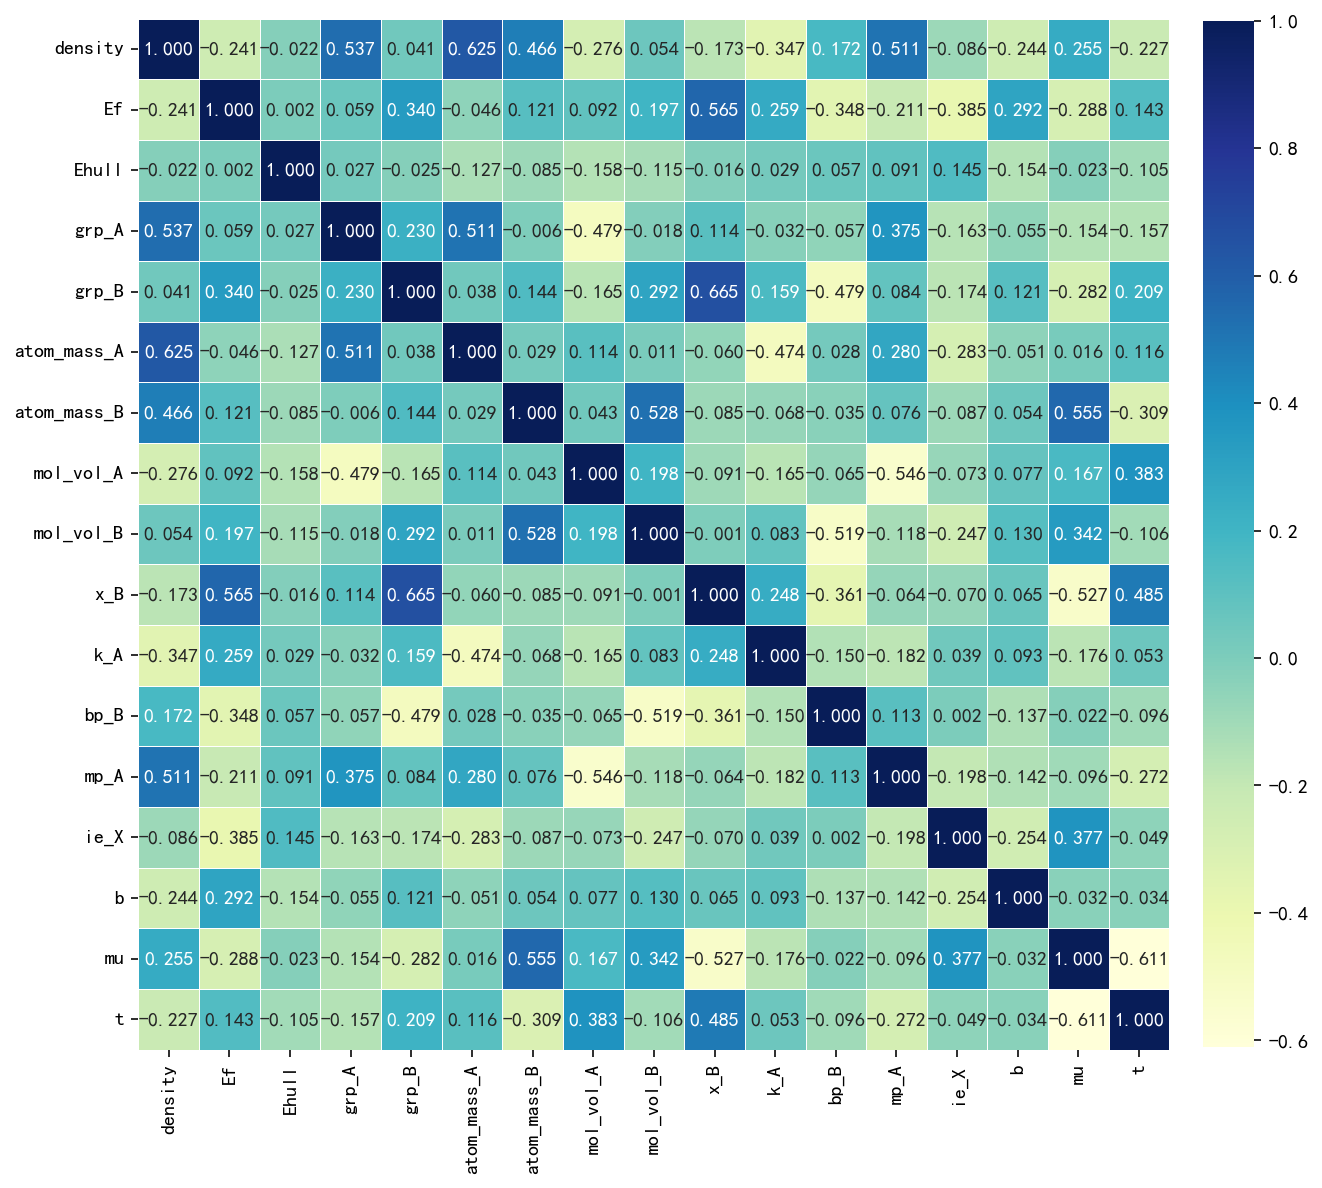

In [28]:
cor = plot_corrcoef_heatmap(new_X, fig_size=(10, 10))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    new_X, y, test_size=0.2, random_state=3
) 
model = gbr.fit(X_train, y_train)
    
GBR_test_pred = gbr.predict(X_test)
r2 = r2_score(y_test, GBR_test_pred)
RMSE = mean_squared_error(y_test, GBR_test_pred)**0.5
MAE = mean_absolute_error(y_test, GBR_test_pred)    

least_feature_list = ["first"] 
r2_list = [r2]          
RMSE_list = [RMSE]
MAE_list = [MAE]

print('r^2:', r2, '\nRMSE:', RMSE, '\nMAE:', MAE)

r^2: 0.8540004226976841 
RMSE: 0.5774985286183019 
MAE: 0.3947624955030487


In [30]:
scores = cross_val_score(gbr, X_train, y_train, cv=5)
print(scores)
print(scores.mean())

[0.76304298 0.71785875 0.75543482 0.78989938 0.87530413]
0.7803080115758088


In [31]:
print("delete features: ", len(delete_features), " residual features: ：", len(new_X.columns))

# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
explainer.expected_value = explainer.expected_value[0]
shap_values = explainer(X_train) # shap.Explanation
# shap_values = explainer.shap_values(X_train) # numpy.array

mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame(mean_abs_shap, columns=["mean_shap"], dtype=float)
shap_df = shap_df.sort_values(by="mean_shap")

feature_names = X_train.columns
sorted_features = feature_names[shap_df.index]
print(sorted_features)

delete features:  51  residual features: ： 17
Index(['k_A', 'mol_vol_A', 'atom_mass_A', 'ie_X', 'grp_A', 't', 'mu', 'x_B',
       'mp_A', 'b', 'mol_vol_B', 'grp_B', 'bp_B', 'Ehull', 'atom_mass_B',
       'density', 'Ef'],
      dtype='object')


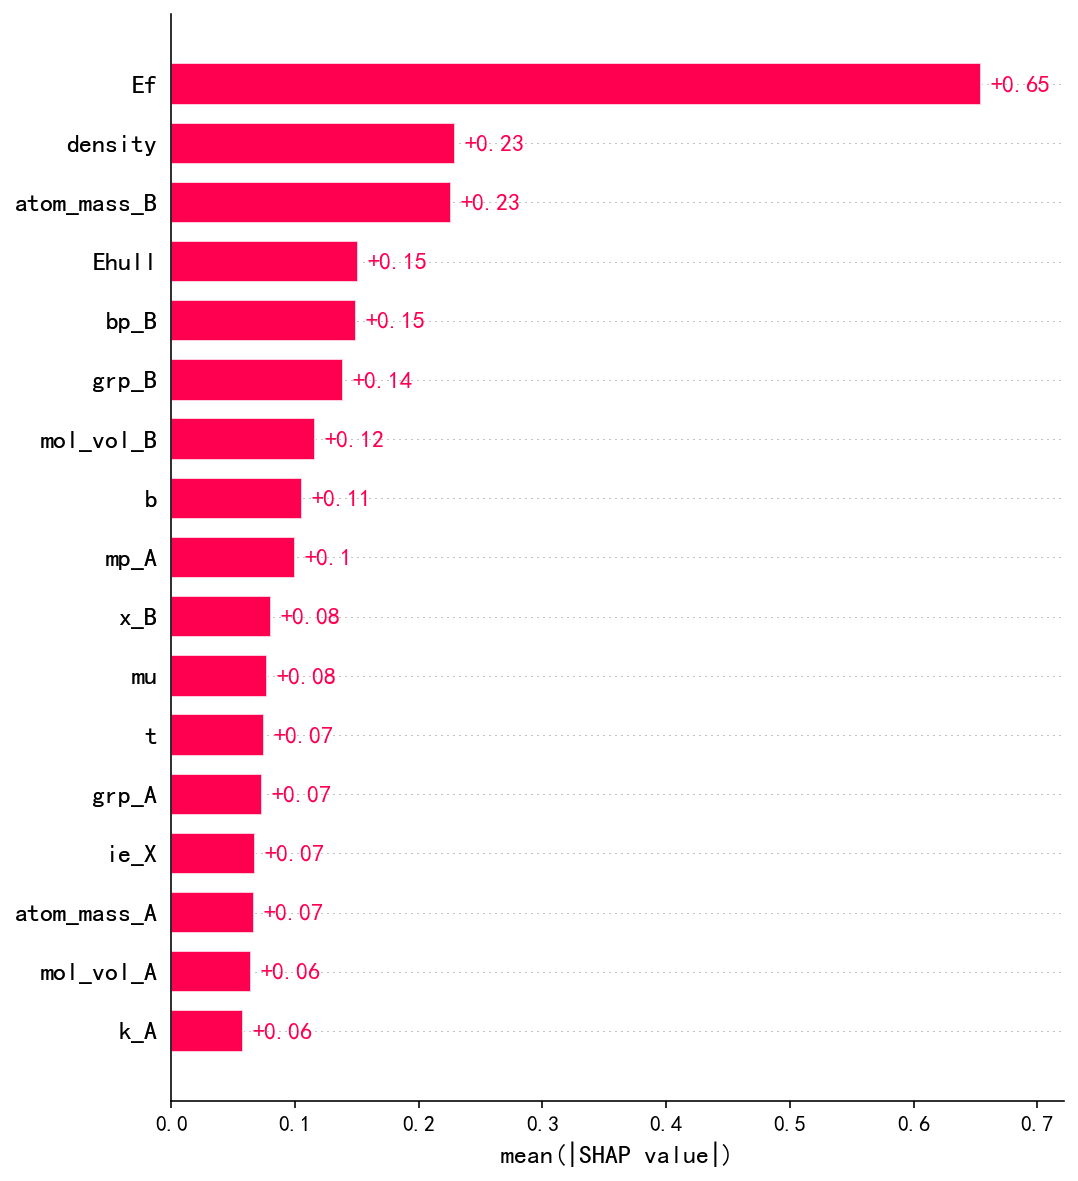

In [32]:
shap.plots.bar(shap_values, max_display=17)

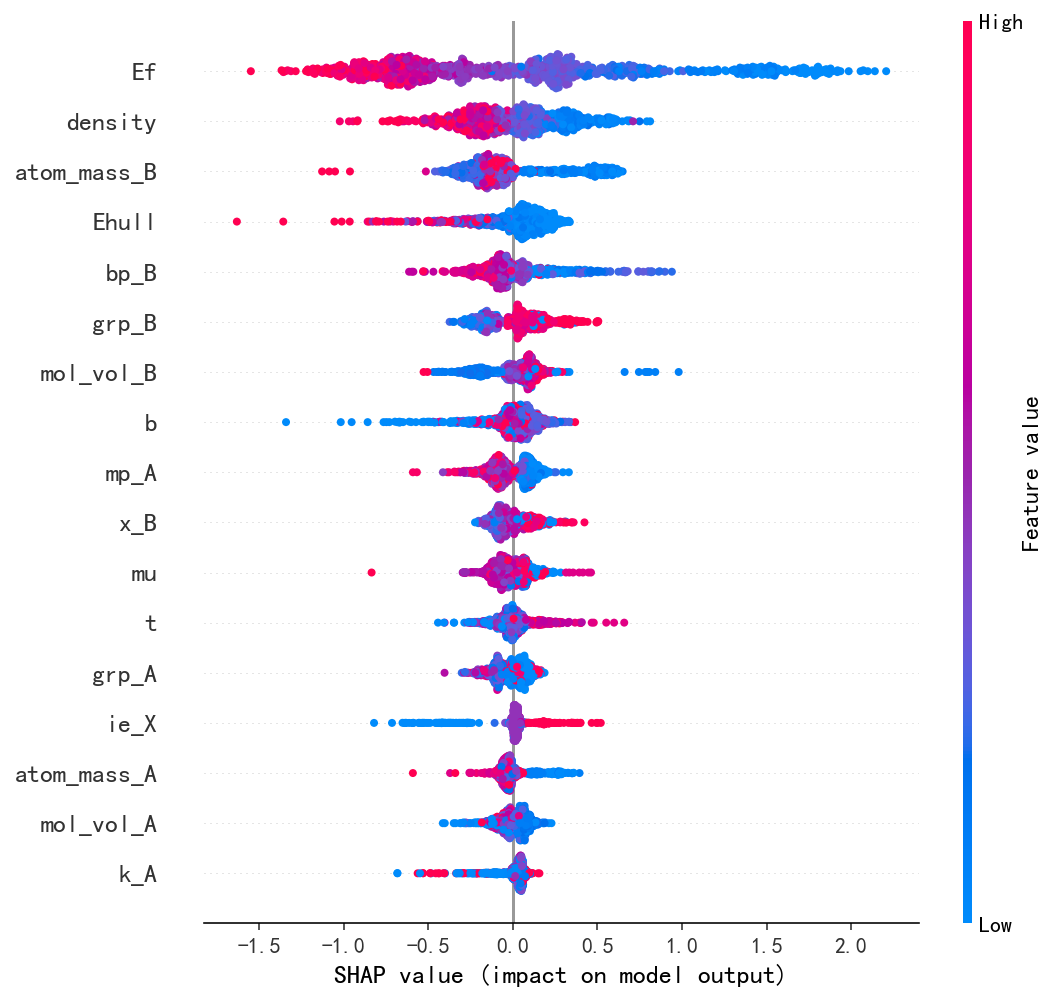

In [33]:
import copy    
shap.plots.beeswarm(copy.deepcopy(shap_values), max_display=17)

In [34]:
shap_sorted_index = np.argsort(mean_abs_shap)[-17:]
pos = np.arange(shap_sorted_index.shape[0]) + 0.5 
shap_importance = np.array(feature_names)[shap_sorted_index]

In [35]:
from matplotlib import rcParams

config = {
    "font.family":'serif',
    "font.size": 15,
    "mathtext.fontset":'stix',
    "font.serif": ['Times New Roman'],
}
rcParams.update(config)

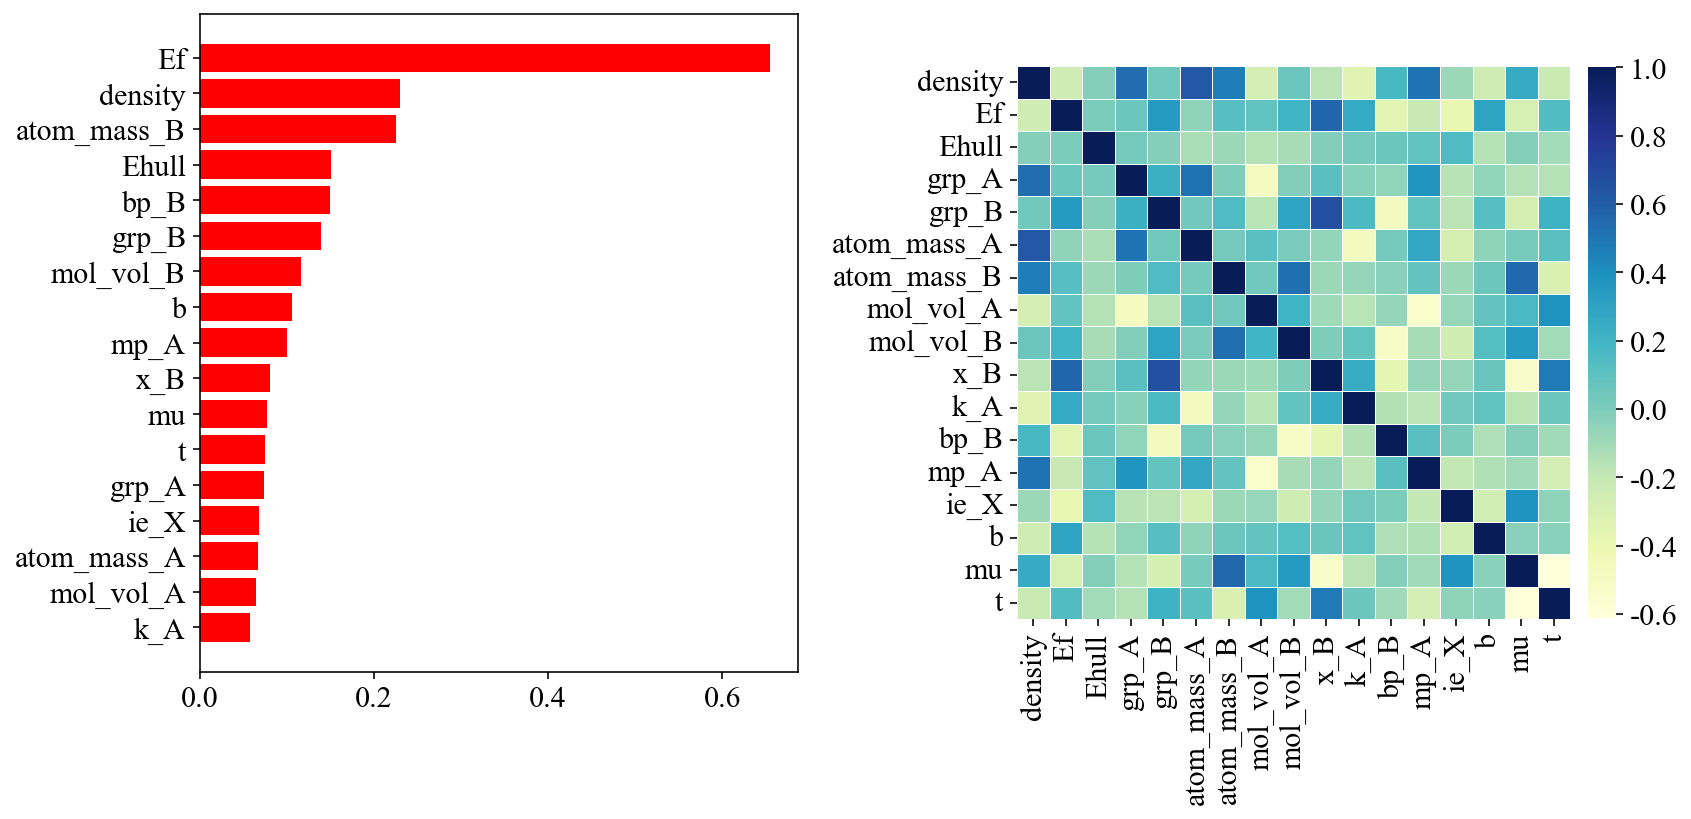

In [36]:
fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(pos, mean_abs_shap[shap_sorted_index], align="center", color="red")
plt.yticks(pos, shap_importance)
plt.xticks(fontproperties='Times New Roman', size=15)
plt.yticks(fontproperties='Times New Roman', size=15)

plt.subplot(1, 2, 2)
ax = sns.heatmap(data_cor,square=True,
                linewidths=.5,cmap="YlGnBu",
                cbar_kws={"fraction":0.046, "pad":0.03})
plt.xticks(fontproperties='Times New Roman', size=15)
plt.yticks(fontproperties='Times New Roman', size=15)

fig.tight_layout()
plt.show()

### band gap prediction with Ef
1.default parameters

In [37]:
X = data_1.drop(['band_gap', 'Ehull'], axis=1)
print(type(X), X.shape)

y = data_1[['band_gap']].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3
)
print("training set: ",len(X_train)," test set: ",  len(X_test))

<class 'pandas.core.frame.DataFrame'> (1341, 67)
training set:  1072  test set:  269


In [38]:
tuned_params_gbr = {
    "random_state": [3]
}

In [39]:
params = {}
for k,v in tuned_params_gbr.items():
    params[k] = v[0]
gbr = ensemble.GradientBoostingRegressor(**params)

In [40]:
model = gbr.fit(X_train, y_train)

In [41]:
GBR_test_pred = gbr.predict(X_test)
r2 = r2_score(y_test, GBR_test_pred)
RMSE = mean_squared_error(y_test, GBR_test_pred)**0.5
MAE = mean_absolute_error(y_test, GBR_test_pred)
    
print('r^2:', r2, '\nRMSE:', RMSE, '\nMAE:', MAE)

r^2: 0.7736325898113487 
RMSE: 0.719087987677693 
MAE: 0.536699102584547


In [42]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(gbr, X_train, y_train, cv=5)

In [43]:
print(scores)
print(scores.mean())

[0.7303626  0.64727626 0.72657705 0.72844564 0.79188175]
0.7249086594055134


2.optimized parameters

In [44]:
tuned_params_gbr = {'random_state': [3],
                     'n_estimators': [1700],
                     'learning_rate': [0.07],
                     'max_depth': [3],
                     'min_samples_split': [2],
                     'min_samples_leaf': [1],
                     'max_features': [10]}

In [45]:
params = {}
for k,v in tuned_params_gbr.items():
    params[k] = v[0]
gbr = ensemble.GradientBoostingRegressor(**params)

In [46]:
model = gbr.fit(X_train, y_train)

In [47]:
GBR_test_pred = gbr.predict(X_test)
r2 = r2_score(y_test, GBR_test_pred)
RMSE = mean_squared_error(y_test, GBR_test_pred)**0.5
MAE = mean_absolute_error(y_test, GBR_test_pred)
    
print('r^2:', r2, '\nRMSE:', RMSE, '\nMAE:', MAE)

r^2: 0.8524106977448559 
RMSE: 0.5806340796043049 
MAE: 0.4108080723036993


In [48]:
scores = cross_val_score(gbr, X_train, y_train, cv=5)

In [49]:
print(scores)
print(scores.mean())

[0.76076589 0.72739377 0.80459058 0.77217916 0.8773592 ]
0.7884577202415369
